In [4]:

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import importlib 
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import os 
import time
from pathlib import Path
if sys.version_info < (3, 0):
    import ConfigParser
else:
    import configparser as ConfigParser
    
import pyzelda.zelda as zelda
import pyzelda.ztools as ztools
import pyzelda.utils.aperture as aperture

# path to the folder that contains your module/package
module_dir = Path('/Users/bencb/Documents/ASGARD/BaldrApp/')  # e.g. Path.home() / "projects/my_pkg/src"
sys.path.insert(0, str(module_dir))  

from baldrapp.common import baldr_core as bldr
from baldrapp.common import DM_basis
from baldrapp.common import utilities as util
from baldrapp.common import phasescreens as ps

import aotools

def upsample_by_factor(ar: np.ndarray, f: int | tuple[int, int]) -> np.ndarray:
    """
    Upsample 2D array by integer factor(s) via block replication (nearest-neighbour).
    If f is an int, uses the same factor on both axes. If f=(fy, fx), uses per-axis factors.
    """
    ar = np.asarray(ar)
    if ar.ndim != 2:
        raise ValueError("ar must be 2D")
    fy, fx = (f, f) if isinstance(f, int) else f
    if fy < 1 or fx < 1:
        raise ValueError("factors must be positive integers")
    return np.repeat(np.repeat(ar, fy, axis=0), fx, axis=1)


def pad_to_shape_edge(arr: np.ndarray, target_shape: tuple[int, int]) -> np.ndarray:
    """
    Grow a 2D array to target_shape by copying its edges (last row/col).
    Equivalent to np.pad(..., mode='edge').
    """
    if arr.ndim != 2:
        raise ValueError("arr must be 2D")
    m, n = arr.shape
    M, N = target_shape
    if M < m or N < n:
        raise ValueError("target_shape must be >= current shape in both dims")

    pad_rows = M - m
    pad_cols = N - n
    return np.pad(arr, ((0, pad_rows), (0, pad_cols)), mode="edge")


def upsample( ar, target_size ):
    out_almost = upsample_by_factor(ar, target_size//len(ar) ) # 
    if np.mod( target_size, len(ar) ) != 0: # not even divisor, we just pad! 
        out = pad_to_shape_edge( out_almost , target_shape = (target_size,target_size))
    else :
        out = out_almost
    return( out )


def update_scintillation( high_alt_phasescreen , pxl_scale, wavelength, final_size = None,jumps = 1,propagation_distance=10000):
    for _ in range(jumps):
        high_alt_phasescreen.add_row()
    wavefront = np.exp(1J *  high_alt_phasescreen.scrn ) # amplitude mean ~ 1 
    propagated_screen = aotools.opticalpropagation.angularSpectrum(inputComplexAmp=wavefront,
                                                               z=propagation_distance, 
                                                               wvl=wavelength, 
                                                               inputSpacing = pxl_scale, 
                                                               outputSpacing = pxl_scale
                                                               )
    #print("upsample it scintillation screen")
    if final_size is not None:
        amp = upsample(propagated_screen, final_size ) # This oversamples to nearest multiple size, and then pads the rest with repeated rows, not the most accurate but fastest. Negligible if +1 from even number
    else:
        amp = propagated_screen

    return( abs(amp) ) # amplitude of field, not intensity (amp^2)! rotate 90 degrees so not correlated with phase 







In [21]:
##################################################################
# Config
##################################################################
grid_dict = {
    "telescope":"DISC", #'AT',
    "D":1.8, # diameter of beam 
    "N" : 72, #64, # number of pixels across pupil diameter
    "dim": 72 * 4, #64 * 4 #4 
    #"padding_factor" : 4, # how many pupil diameters fit into grid x axis
    # TOTAL NUMBER OF PIXELS = padding_factor * N 
    }

# I should include coldstop here!! 
optics_dict = {
    "wvl0" :1.65e-6, # central wavelength (m) 
    "F_number": 21.2, # F number on phasemask
    "mask_diam": 1.06, # diameter of phaseshifting region in diffraction limit units (physical unit is mask_diam * 1.22 * F_number * lambda)
    "theta": 1.57079, # phaseshift of phasemask 
    ### NEw have not consistenty propagate this in functions in baldr_core
    "coldstop_diam": 8, #1.22 lambda/D units
    "coldstop_offset":(0.0, 0.0)
}

dm_dict = {
    "dm_model":"BMC-multi-3.5",
    "actuator_coupling_factor":0.7,# std of in actuator spacing of gaussian IF applied to each actuator. (e.g actuator_coupling_factor = 1 implies std of poke is 1 actuator across.)
    "dm_pitch":1,
    "dm_aoi":0, # angle of incidence of light on DM 
    "opd_per_cmd" : 3e-6, # peak opd applied at center of actuator per command unit (normalized between 0-1) 
    "flat_rmse" : 20e-9 # std (m) of flatness across Flat DM  
    }

grid_ns = SimpleNamespace(**grid_dict)
optics_ns = SimpleNamespace(**optics_dict)
dm_ns = SimpleNamespace(**dm_dict)

## Main ZWFS object 
zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns, dm_ns)

# Dont use pyZelda machinary 
use_pyZelda = False 

##################################################################
# grid 
##################################################################
dx = zwfs_ns.grid.D / zwfs_ns.grid.N # m / pixel in simulation grid 


##################################################################
# stellar
##################################################################
throughput = 1 #0.1
waveband = "H" 
magnitude = -5

##################################################################
# detector 
##################################################################
detector = bldr.detector(binning=6 ,dit=1.0,ron=1.0,qe=1.0)
zwfs_ns.detector = detector

##################################################################
## basis 
##################################################################
basis_name = 'Zonal_pinned_edges'
Nmodes = 100
M2C_0 = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  

##################################################################
# Calibration fields from intenal source 
##################################################################
calibration_opd_input=0 * np.zeros_like(zwfs_ns.grid.pupil_mask)

calibration_amp_input = (throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask

opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)



##################################################################
# Build Interaction Matrix 
##################################################################
poke_amp=0.05
poke_method="double_sided_poke"
basis_name = "Zonal"
imgs_to_mean=10


# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

# build reconstructor name space with normalized basis, IM generated, IM generation method, pokeamp 
modal_basis = DM_basis.construct_command_basis( basis= basis_name , number_of_modes = Nmodes, without_piston=True).T 

IM=[] # init our raw interaction matrix 

I0_list = []
for _ in range(imgs_to_mean) :
    I0_list .append( bldr.get_I0( opd_input  =calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda )  )
I0 = np.mean( I0_list ,axis =0 )

N0_list = []
for _ in range(imgs_to_mean) :
    N0_list.append( bldr.get_N0( opd_input  = calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda )  )
N0 = np.mean( N0_list ,axis =0 )



if poke_method=='double_sided_poke':
    for i,m in enumerate(modal_basis):
        print(f'executing cmd {i}/{len(modal_basis)}')
        I_plus_list = []
        I_minus_list = []
        for sign in [(-1)**n for n in range(np.max([2, imgs_to_mean]))]: #[-1,1]:
            
            #ZWFS.dm.send_data( list( ZWFS.dm_shapes['flat_dm'] + sign * poke_amp/2 * m )  )
            zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + sign * poke_amp/2 * m
            
            if sign > 0:
                
                I_plus_list += [list( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = use_pyZelda) ) ]
                
            if sign < 0:
                
                I_minus_list += [list( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ) ) ] 
                

        I_plus = np.mean( I_plus_list, axis = 0).reshape(-1)  # flatten so can filter with ZWFS.pupil_pixels
        I_plus *= 1/np.mean( I_plus )

        I_minus = np.mean( I_minus_list, axis = 0).reshape(-1)  # flatten so can filter with ZWFS.pupil_pixels
        I_minus *= 1/np.mean( I_minus )

        errsig =  (I_plus - I_minus)[np.array( np.ones_like( I0 ).astype(bool).reshape(-1) )]
        IM.append( list(  errsig.reshape(-1) ) ) #toook out 1/poke_amp *

else:
    raise TypeError( ' no matching method for building control model. Try (for example) method="single_side_poke"')

# convert to array 
IM = np.array( IM )  

reco_dict = {
    "I0":I0,
    "N0":N0,
    "M2C_0":modal_basis,
    "basis_name":basis_name,
    "poke_amp":poke_amp,
    "poke_method":poke_method,
    "IM":IM,
}

reco_ns = SimpleNamespace(**reco_dict)

zwfs_ns.reco = reco_ns

# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

##################################################################
# Build Reconstructor 
##################################################################

U, S, Vt = np.linalg.svd( IM, full_matrices=False)

# in /Users/bencb/Documents/ASGARD/BaldrApp/baldrapp/playground/verify.ipynb we found 
# these parameters were best from experimentation
lam = 100             # Tikhonov (set >0 if needed)
#smin = 1e-2 * S.max()    # optional hard gate
smin_idx = 80


# diagonal inverse weights for Σ (Tikhonov)
W = S / (S*S + lam*lam)
#W[S < smin] = 0.0
W[smin_idx:] = 0.0

I2M = (W[:,None] * U.T)  #intensity 2 mode 

M2C = Vt.T # mode to cmd 

# Reconstructor mapping pixel error -> modal coefficients (Nmodes × Npix_eff)
R_modal = M2C @ I2M   
#R_modal = Vt.T @ (W[:,None] * U.T) 



0.009695053100585938
0.009440898895263672
0.009053945541381836
0.009221792221069336
0.009315013885498047
0.00910806655883789
0.009050846099853516
0.009458780288696289
0.009039163589477539
0.00935506820678711
0.009099006652832031
0.010114908218383789
0.009946823120117188
0.009692907333374023
0.00927114486694336
0.00952911376953125
0.009429454803466797
0.009864091873168945
0.009521961212158203
0.009727954864501953
executing cmd 0/140
0.009341239929199219
0.009359121322631836
0.00937795639038086
0.009424209594726562
0.009274959564208984
0.009390830993652344
0.009241819381713867
0.009096860885620117
0.009131908416748047
0.009466886520385742
executing cmd 1/140
0.009678125381469727
0.009646892547607422
0.009267091751098633
0.009327173233032227
0.00927281379699707
0.009356021881103516
0.009088993072509766
0.00939488410949707
0.009144067764282227
0.009199142456054688
executing cmd 2/140
0.009344100952148438
0.008955001831054688
0.009479999542236328
0.00899505615234375
0.009402990341186523
0.0

## Have a quick look at reference intensities and Eigenmodes 

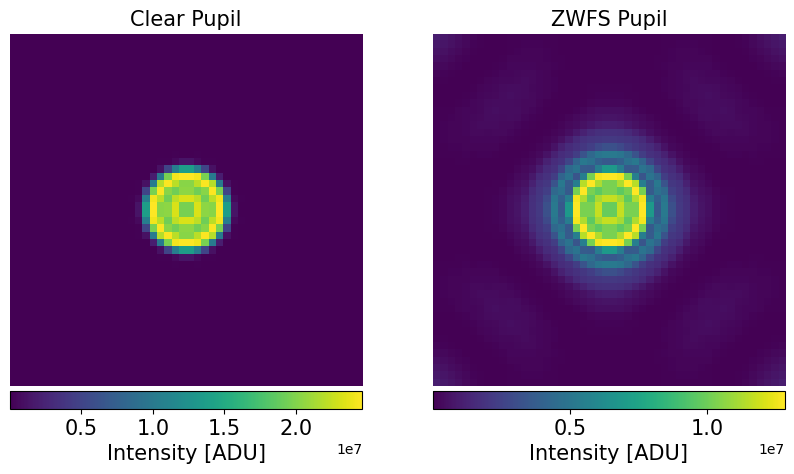

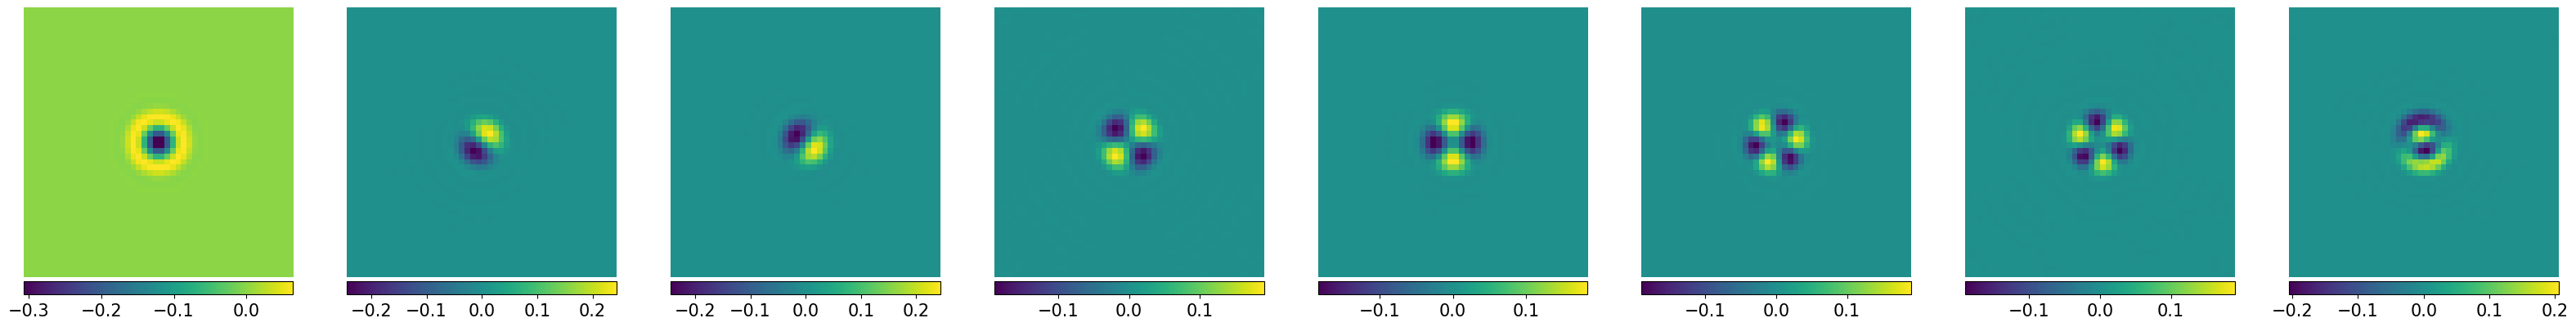

In [22]:
# reference pupil intensities
util.nice_heatmap_subplots(im_list=[N0, I0], title_list=["Clear Pupil","ZWFS Pupil"], cbar_label_list=["Intensity [ADU]","Intensity [ADU]"])
# Eigenmode in detector space
util.nice_heatmap_subplots( im_list=[vv.reshape(48,48) for vv in Vt[:8]])

## Do some closed loop AO 

In [23]:


##################################################################
# atmosphere 
##################################################################
wvl0=1.65e-6 #m

r0_scint = 0.164 #m for high alt scintillation pahse screem
L0_scint  = 10 #m for high alt scintillation pahse screem

r0 = (0.164) * (1.65/0.5)**(6/5) # for atm phase aberrations
L0  = 25 # for atm phase aberrations
phase_scaling_factor = 0.6 # for additional scaling 


scrn = ps.PhaseScreenKolmogorov(nx_size=zwfs_ns.grid.dim, 
                                pixel_scale=dx, 
                                r0=r0, 
                                L0=L0, 
                                random_seed=2)


scint_phasescreen =  aotools.turbulence.infinitephasescreen.PhaseScreenVonKarman(nx_size=zwfs_ns.grid.dim, 
                                                                                 pixel_scale=dx, 
                                                                                 r0 = r0_scint, 
                                                                                 L0 = L0_scint)



##################################################################
# First State AO Zernike Basis 
##################################################################

basis_cropped = ztools.zernike.zernike_basis(nterms=50, npix=zwfs_ns.grid.N)
# we have padding around telescope pupil (check zwfs_ns.pyZelda.pupil.shape and zwfs_ns.pyZelda.pupil_diameter) 
# so we need to put basis in the same frame  
basis_template = np.zeros( zwfs_ns.grid.pupil_mask.shape )
basis = np.array( [ util.insert_concentric( np.nan_to_num(b, 0), basis_template) for b in basis_cropped] )

# number of modes controlled in first stage AO 
Nmodes_removed = 0 

##################################################################
# Init before Close Loop
##################################################################

# leaky integrator gain 
alpha = 0.98

# delta cmd that we control relative to flat 
dcmd = np.zeros(140)

# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

# put DM in opd space 
opd_current_dm = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


# input stellar flux (before addeing scintillation)
amp_input_0 = (throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask


# get reference intensity 
I0 = bldr.get_I0( opd_input  = 0 * calibration_opd_input,    amp_input = amp_input_0  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ).astype(float) #bldr.get_frame( 0 * opd_internal,   amp_input_0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
#I0 = bldr.get_frame( 0 * opd_internal,   amp_input_0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)  #bldr.get_I0( opd_input  = 0 * calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ).astype(float) #bldr.get_frame( 0 * opd_internal,   amp_input_0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) #
I0 /= np.mean(I0)

N0 = bldr.get_N0( opd_input  = 0 *calibration_opd_input,    amp_input = amp_input_0  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ).astype(float) 
N0 /= np.mean(N0)

print("\n\nSTARTING CLOSED LOOP SIMULATION\n\n")
for it in range(100):
        
    ##################################################################
    ## update amplitude screen
    amp_input = amp_input_0 * update_scintillation( high_alt_phasescreen=scint_phasescreen , pxl_scale=dx, wavelength=wvl0, final_size = None, jumps = 1,propagation_distance=10000)

    ## update phase screen
    scrn.add_row() 

    ################################################################## 
    # first stage AO

    #if np.mod(it, 1) == 0: # only update the AO every few iterations to simulate latency 
    _ , reco_1 = bldr.first_stage_ao( scrn, Nmodes_removed =  Nmodes_removed  , basis = basis , phase_scaling_factor = phase_scaling_factor, return_reconstructor = True )   
        
    ao_1 =  basis[0] * (phase_scaling_factor * scrn.scrn - reco_1)

    opd_input = phase_scaling_factor * wvl0 / (2*np.pi) * ao_1  #scrn.scrn #0.3 * wvl0 / (2*np.pi) * basis[1] 

    #no_baldr_strehl.append( np.exp( -(np.std( 2*np.pi / wvl0 * opd_input[zwfs_ns.grid.pupil_mask.astype(bool)] ) )**2 ) )
    
    ##################################################################
    # calculate residual in wavespace based on current baldr DM cmd (before d)
    residual_wavespace = opd_input + opd_current_dm
    residual_wavespace = residual_wavespace - np.mean( residual_wavespace[ zwfs_ns.grid.pupil_mask.astype(bool)] )
    
    #res_list.append( np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]) )
    #strehl_list.append( np.exp( -(2*np.pi / wvl0 * np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ) )
    print( np.std(residual_wavespace[zwfs_ns.grid.pupil_mask.astype(bool)]) )



    ##################################################################
    # get new frame 
    ii = bldr.get_frame( opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) 
    ii /= np.mean(ii)
    # get signal 
    y_err = (ii - I0).reshape(-1)  # must match how A was built
    ##################################################################
    # Reconstructor 

    # for now just do ctrl in DM space with leaky integrator 
    c_hat = R_modal.T @ y_err   

    u_cmd = c_hat

    dcmd = alpha * dcmd + u_cmd

    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat - 1 * dcmd

    # calculate the new DM OPD in wavespace 
    opd_current_dm = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


strehl_before_baldr = np.exp( -(2*np.pi / wvl0 * np.std(opd_input[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 )

strehl_after_baldr = np.exp( -(2*np.pi / wvl0 * np.std(residual_wavespace[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 )

print( f"final strehl before baldr = {strehl_before_baldr}")
print( f"final strehl after baldr = {strehl_after_baldr}")


0.01902294158935547
0.012457132339477539


STARTING CLOSED LOOP SIMULATION


1.643095819364805e-07
0.017307043075561523
1.295936303585193e-07
0.01892995834350586
1.1525307289654727e-07
0.02010798454284668
1.0883415414578653e-07
0.01669907569885254
1.0596350883080518e-07
0.013471126556396484
1.0468311086880676e-07
0.010063886642456055
1.0399676083112701e-07
0.016058921813964844
1.0362370656091524e-07
0.02005600929260254
1.0355471982378343e-07
0.015650033950805664
1.0364115220152234e-07
0.01862812042236328
1.038170582936582e-07
0.016215801239013672
1.0407266171427832e-07
0.009861946105957031
1.043756834171965e-07
0.0231931209564209
1.0494698892173371e-07
0.017597198486328125
1.0575524620930985e-07
0.01604914665222168
1.0681321980950645e-07
0.016629934310913086
1.0815244002260332e-07
0.010597944259643555
1.0963283456753188e-07
0.011915922164916992
1.108764654069005e-07
0.012084007263183594
1.1171491894218491e-07
0.010273933410644531
1.1220148944339021e-07
0.027876853942871094
1.1256997440

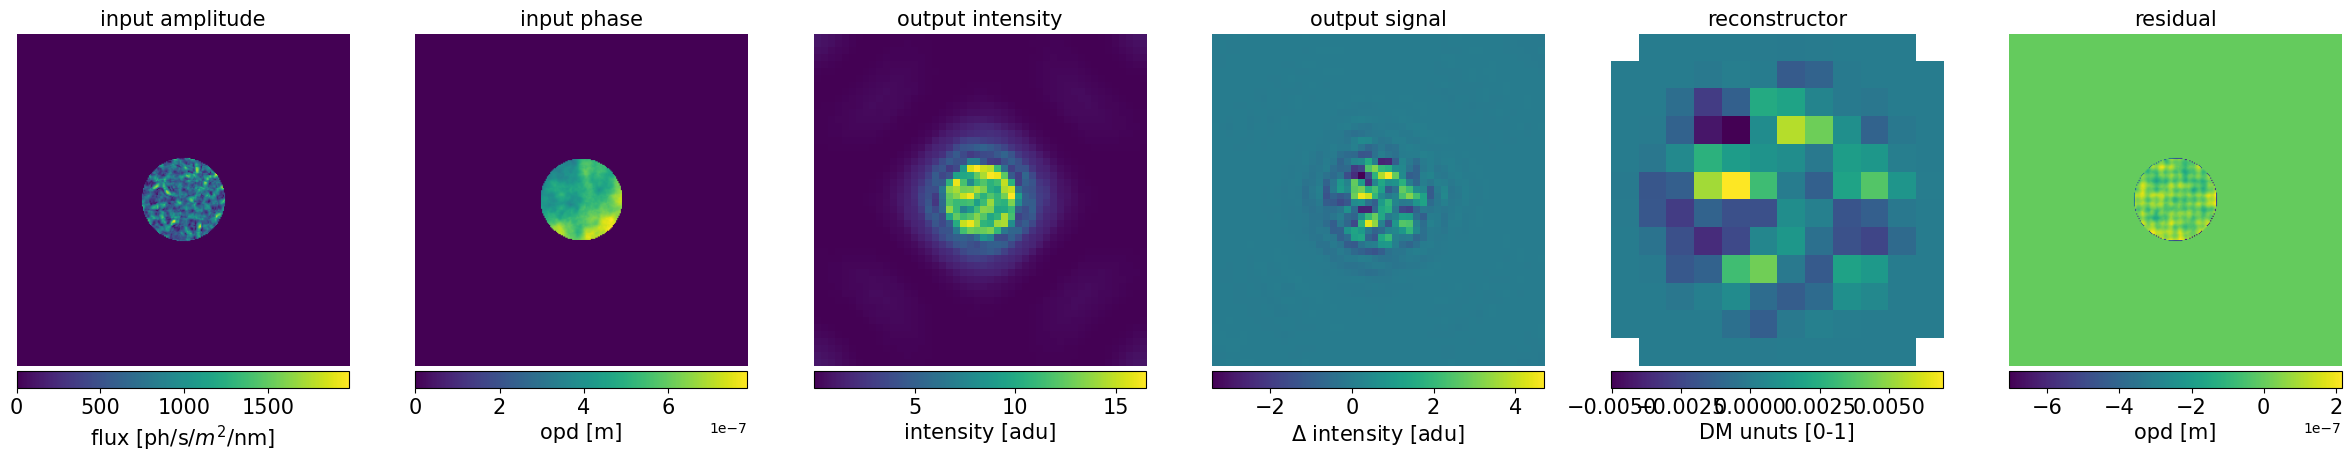

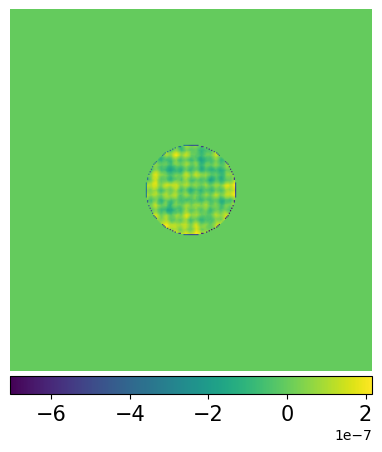

In [24]:
util.nice_heatmap_subplots(im_list=[amp_input,zwfs_ns.grid.pupil_mask *  opd_input,ii, ii-I0, util.get_DM_command_in_2D(u_cmd), zwfs_ns.grid.pupil_mask * residual_wavespace], #c_hat)], 
                           title_list=["input amplitude","input phase","output intensity","output signal","reconstructor","residual"],
                            cbar_label_list=[f"flux [ph/s/$m^2$/nm]", "opd [m]","intensity [adu]",r"$\Delta$ intensity [adu]","DM unuts [0-1]","opd [m]"])


util.nice_heatmap_subplots(im_list=[ zwfs_ns.grid.pupil_mask * residual_wavespace] ) 
                          


## Try again with mis-aligned coldstop 

In [ ]:
##################################################################
# mis-algin coldstop
##################################################################

optics_dict_misaligned = {
    "wvl0" :1.65e-6, # central wavelength (m) 
    "F_number": 21.2, # F number on phasemask
    "mask_diam": 1.06, # diameter of phaseshifting region in diffraction limit units (physical unit is mask_diam * 1.22 * F_number * lambda)
    "theta": 1.57079, # phaseshift of phasemask 
    ### NEw have not consistenty propagate this in functions in baldr_core
    "coldstop_diam": 8, #1.22 lambda/D units
    "coldstop_offset":(1.0, 0.0)
}


optics_ns_misaligned = SimpleNamespace(**optics_dict_misaligned)

## Main ZWFS object 
zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns_misaligned, dm_ns)


##### ADD INTERNAL FOCUS OFFSET  (80nm RMS)
#opd_internal= 0.3 * wvl0/(2*np.pi) * basis[3] #np.zeros_like(zwfs_ns.grid.pupil_mask)

# or no internal offset
opd_internal= np.zeros_like(zwfs_ns.grid.pupil_mask)


##################################################################
# atmosphere 
##################################################################


scrn = ps.PhaseScreenKolmogorov(nx_size=zwfs_ns.grid.dim, 
                                pixel_scale=dx, 
                                r0=r0, 
                                L0=L0, 
                                random_seed=2)


scint_phasescreen =  aotools.turbulence.infinitephasescreen.PhaseScreenVonKarman(nx_size=zwfs_ns.grid.dim, 
                                                                                 pixel_scale=dx, 
                                                                                 r0 = r0_scint, 
                                                                                 L0 = L0_scint)




##################################################################
# Init before Close Loop
## Note we do I0 update with coldstop mis-aligned
##################################################################


# delta cmd that we control relative to flat 
dcmd = np.zeros(140)

# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

# put DM in opd space 
opd_current_dm = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


##########

#get reference intensity 
I0 = bldr.get_I0( opd_input  = 0 * calibration_opd_input,
                   amp_input = amp_input_0  , 
                   opd_internal= 0 * opd_internal,  
                   zwfs_ns=zwfs_ns , 
                   detector=detector, 
                   use_pyZelda = use_pyZelda ).astype(float) #bldr.get_frame( 0 * opd_internal,   amp_input_0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
#I0 = bldr.get_frame( 0 * opd_internal,   amp_input_0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)  #bldr.get_I0( opd_input  = 0 * calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ).astype(float) #bldr.get_frame( 0 * opd_internal,   amp_input_0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) #
I0 /= np.mean(I0)

N0 = bldr.get_N0( opd_input  = 0 *calibration_opd_input, 
                 amp_input = amp_input_0  ,
                 opd_internal= 0 * opd_internal,
                 zwfs_ns=zwfs_ns , 
                 detector=detector, 
                 use_pyZelda = use_pyZelda ).astype(float) 
N0 /= np.mean(N0)

print("\n\nSTARTING CLOSED LOOP SIMULATION\n\n")
for it in range(100):
        
    ##################################################################
    ## update amplitude screen
    amp_input = amp_input_0 * update_scintillation( high_alt_phasescreen=scint_phasescreen , pxl_scale=dx, wavelength=wvl0, final_size = None, jumps = 1,propagation_distance=10000)

    ## update phase screen
    scrn.add_row() 

    ################################################################## 
    # first stage AO

    #if np.mod(it, 1) == 0: # only update the AO every few iterations to simulate latency 
    _ , reco_1 = bldr.first_stage_ao( scrn, Nmodes_removed =  Nmodes_removed  , basis = basis , phase_scaling_factor = phase_scaling_factor, return_reconstructor = True )   
        
    ao_1 =  basis[0] * (phase_scaling_factor * scrn.scrn - reco_1)

    opd_input = phase_scaling_factor * wvl0 / (2*np.pi) * ao_1  #scrn.scrn #0.3 * wvl0 / (2*np.pi) * basis[1] 

    #no_baldr_strehl.append( np.exp( -(np.std( 2*np.pi / wvl0 * opd_input[zwfs_ns.grid.pupil_mask.astype(bool)] ) )**2 ) )
    
    ##################################################################
    # calculate residual in wavespace based on current baldr DM cmd (before d)
    residual_wavespace = opd_input + opd_current_dm
    residual_wavespace = residual_wavespace - np.mean( residual_wavespace[ zwfs_ns.grid.pupil_mask.astype(bool)] )
    
    #res_list.append( np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]) )
    #strehl_list.append( np.exp( -(2*np.pi / wvl0 * np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ) )
    print( np.std(residual_wavespace[zwfs_ns.grid.pupil_mask.astype(bool)]) )



    ##################################################################
    # get new frame 
    ii = bldr.get_frame( opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) 
    ii /= np.mean(ii)
    # get signal 
    y_err = (ii - I0).reshape(-1)  # must match how A was built
    ##################################################################
    # Reconstructor 

    # for now just do ctrl in DM space with leaky integrator 
    c_hat = R_modal.T @ y_err   

    u_cmd = c_hat

    dcmd = alpha * dcmd + u_cmd

    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat - 1 * dcmd

    # calculate the new DM OPD in wavespace 
    opd_current_dm = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


strehl_before_baldr = np.exp( -(2*np.pi / wvl0 * np.std(opd_input[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 )

strehl_after_baldr = np.exp( -(2*np.pi / wvl0 * np.std(residual_wavespace[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 )

print( f"final strehl before baldr = {strehl_before_baldr}")
print( f"final strehl after baldr = {strehl_after_baldr}")


0.014681100845336914
0.010458946228027344


STARTING CLOSED LOOP SIMULATION


1.6430958117919544e-07
0.013726949691772461
1.3165909573647297e-07
0.009688138961791992
1.2542677755838443e-07
0.013359785079956055
1.2435288281559828e-07
0.010075092315673828
1.2471234496635685e-07
0.0098419189453125
1.2554821219962685e-07
0.011841058731079102
1.2644849187120735e-07
0.012578010559082031
1.2721287322195342e-07
0.016566991806030273
1.2789842945771365e-07
0.01556396484375
1.2838696110887652e-07
0.017384052276611328
1.287807255093768e-07
0.009654998779296875
1.291369757828481e-07
0.011564970016479492
1.2943030709280553e-07
0.010560035705566406
1.2987030389613915e-07
0.012558698654174805
1.304124902650049e-07
0.009667634963989258
1.3106704968891652e-07
0.01696300506591797
1.3173816062381714e-07
0.016881942749023438
1.324337968235908e-07
0.024307966232299805
1.3307700274069177e-07
0.017089128494262695
1.3369510573193365e-07
0.010188102722167969
1.3426876078654812e-07
0.010130882263183594
1.3507037

In [41]:
np.std(0.3 * wvl0/(2*np.pi) * basis[3][zwfs_ns.grid.pupil_mask.astype(bool)]) * 1e9

77.23727542414814

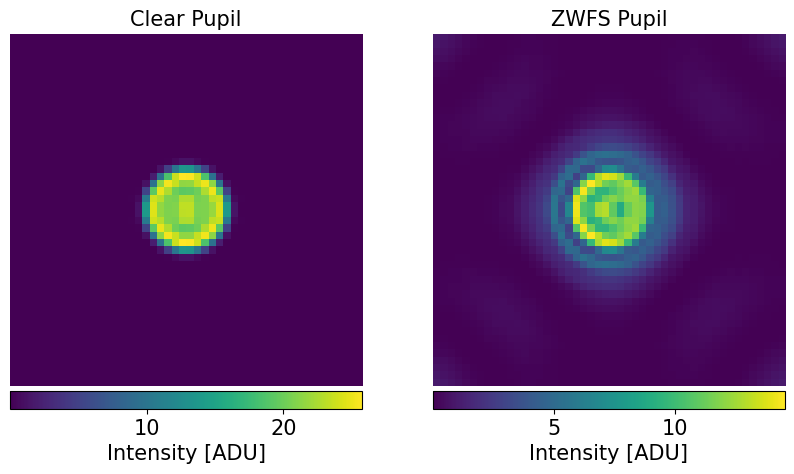

In [34]:
util.nice_heatmap_subplots(im_list=[N0, I0] , title_list=["Clear Pupil","ZWFS Pupil"], cbar_label_list=["Intensity [ADU]","Intensity [ADU]"])

In [55]:
np.exp( -(2*np.pi / wvl0 * np.std(residual_wavespace[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 )

np.exp( -(2*np.pi / wvl0 * np.std(opd_input[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 )


0.7784655109363781